In [2]:
import torch
import pprint as pp
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import numpy as np

import matplotlib.pyplot as plt

In [3]:
# hyperparameters

batch_size = 64
learning_rate = 0.01
weight_decay = 1e-5
momentum = 0.5

In [4]:
# Create data loaders.

transform = torchvision.transforms.Compose([
              torchvision.transforms.RandomCrop(28, 1),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize((0.1307,), (0.3081,))
              #torchvision.transforms.RandomRotation(20)
            ])
train_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw




Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw




Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw




Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [6]:
class Autoencoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.predictor = nn.Sequential(
            # N, 1, 28, 28
            nn.Conv2d(1, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64), 
            nn.ReLU(True),
            nn.MaxPool2d(2), # 14
            
            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(True),

            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(True),
            nn.MaxPool2d(2), # 7
            
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(True),

            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128), 
            nn.ReLU(True),  
#           nn.AdaptiveAvgPool(1)
        )

        self.lin = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 196),
            nn.ReLU(True),
            
            nn.Linear(196, 392),
            nn.ReLU(True),
            
            nn.Linear(392, 28*28),            
            
        )
        
    def forward(self, x):
        x = self.predictor(x)
        x = x.mean(-1).mean(-1)
        y = self.lin(x)        
        x_rec = self.decoder(y)#.view(64,1,28,28)
        return x_rec.view(-1,1,28,28), y

model = Autoencoder_conv().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
model

Autoencoder_conv(
  (predictor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [7]:
def train(dataloader, model, optimizer, alpha):
    model.train()
    criterion1 = nn.NLLLoss().to(device)
    criterion2 = nn.MSELoss().to(device)
    for (x, y_true) in dataloader:
        x, y_true = x.to(device), y_true.to(device)
        x_rec, y = model(x)
        x_rec, y = x_rec.to(device), y.to(device)
        loss = criterion1(y, y_true) + alpha*criterion2(x_rec, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    print(loss.item())
    return np.array([loss.item(), x, x_rec])


In [25]:
float_range_array = np.arange(0, 2.4, 0.4)
alpha_list = list(float_range_array)
loss_scores = []

for alpha in alpha_list:
  epochs = 10
  outputs = []
  total_loss = 0
  for epoch in range(epochs):

      print(f"Epoch {epoch+1}\n-------------------------------")
      output = train(train_dataloader, model, optimizer, alpha)
      outputs.append(output)
      total_loss += output[0]
  avg_loss = total_loss/epochs
  loss_scores.append(avg_loss)
  print("Finished")


Epoch 1
-------------------------------
Epoch:1, Loss:-1.0000
-0.9999980926513672
Epoch 2
-------------------------------
Epoch:2, Loss:-0.9622
-0.9622169137001038
Finished
Epoch 1
-------------------------------
Epoch:1, Loss:-0.7905
-0.7905169129371643
Epoch 2
-------------------------------
Epoch:2, Loss:-0.8712
-0.8711754083633423
Finished


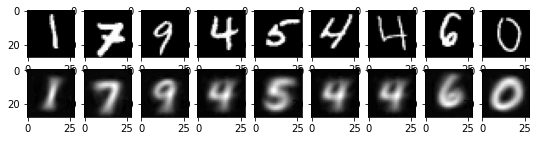

In [23]:
for k in range(0, epochs, 5):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2,9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

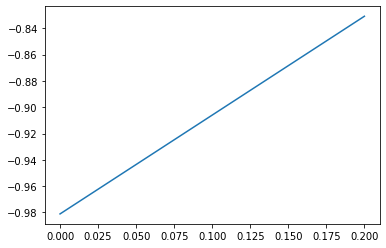

[0.0, 0.2]


In [27]:
plt.plot(alpha_list, loss_scores)
plt.show()
print(alpha_list)